# HR Analytics

For this project, I'm using a public dataset found here:
https://www.kaggle.com/ludobenistant/hr-analytics



In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('HR_comma_sep.csv')

data.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,years_with_company,work_accident,left,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# In a real-world setting, it would be better to have actual
# dollar amounts. It would make our models much more accurate.

# I'm estimating that high salaries are twice as much as the
# average/medium salaries, so I'm using a scale of 1, 2, and 4.

salary_dict = {
    'low': 1,
    'medium': 2,
    'high': 4
}

data['salary'] = data['salary'].map(salary_dict)

We can either label encode or dummify the categorical variables. I chose to dummify them because there weren't too many values and it didn't significantly increase the dimensionality of our data.

In [4]:
data = pd.get_dummies(data, prefix='dummy')

data.shape

(14999, 19)

Now let's examine the correlations between each variable.

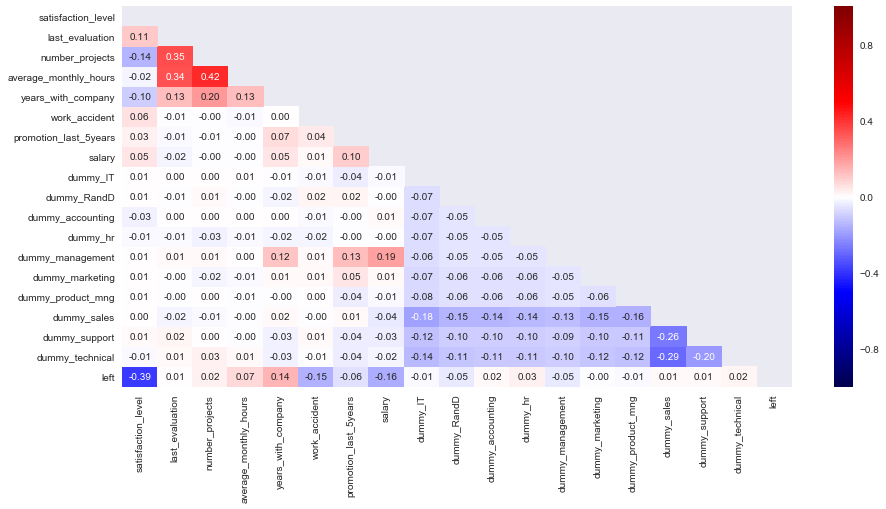

In [5]:
# Move our target variable to the bottom
left = data.pop('left')
data['left'] = left

corrs = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Resize and display
plt.figure(figsize=(15,7))
sns.heatmap(corrs, annot=True, fmt='.2f', mask=mask, cmap='seismic')

The strongest predictor of whether an employee leaves is their job satisfaction. No surprises there.

More senior employees are more likely to leave, and those with higher salaries are less likely to leave. Let's plot some of the more important variables.

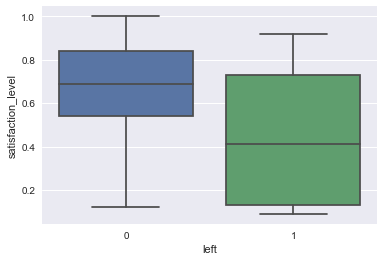

In [6]:
sns.boxplot(x='left', y='satisfaction_level', data=data)

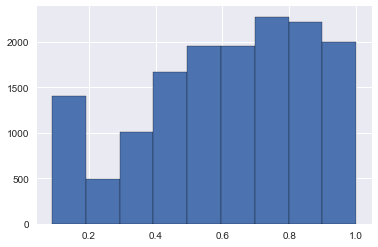

In [7]:
data.satisfaction_level.hist(edgecolor='black', bins=9)

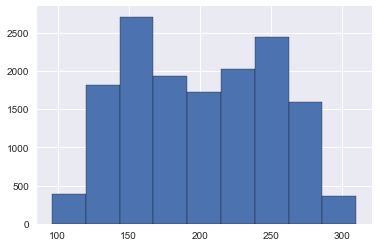

In [8]:
# Interesting bimodal distribution here
data.average_monthly_hours.hist(edgecolor='black', bins=9)

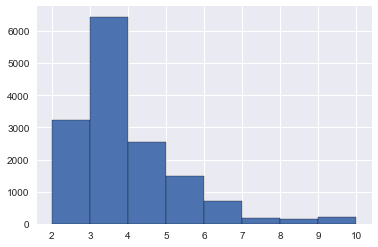

In [9]:
data.years_with_company.hist(edgecolor='black', bins=8)

Are we rewarding company loyalty?

In [10]:
np.corrcoef(data.years_with_company, data.salary)[0,1]

0.049759703423531802

Probably not as much as we should.

# Machine Learning

Let's create a model to predict employee retention!

After trying a few different algorithms, including Logistic Regression, Naive Bayes, K-Nearest Neighbors, and XGBoost, I found that a simple **decision tree** was the best choice. Not only was it among the most accurate, but its results and recommendations can be interpreted easily by non-technical people.

In [11]:
from sklearn.model_selection import GridSearchCV, train_test_split

x = data.drop('left', axis=1)
y = data['left']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

In [12]:
# Comparing Algorithms

lr_cvs = cross_val_score(LogisticRegression(), x, y, cv=5,
                         scoring='roc_auc').mean()
nb_cvs = cross_val_score(GaussianNB(), x, y, cv=5,
                         scoring='roc_auc').mean()
kn_cvs = cross_val_score(KNeighborsClassifier(n_neighbors=3), x, y, cv=5,
                         scoring='roc_auc').mean()
xg_cvs = cross_val_score(XGBClassifier(n_estimators=100), x, y, cv=5,
                         scoring='roc_auc').mean()
tree_cvs = cross_val_score(DecisionTreeClassifier(max_depth=9), x, y, cv=5,
                         scoring='roc_auc').mean()

print('AUC RESULTS')
print('Logistic regression:', lr_cvs)
print('Naive Bayes:', nb_cvs)
print('KNN:', kn_cvs)
print('XGBoost:', xg_cvs)
print('Decision tree:', tree_cvs)

AUC RESULTS
Logistic regression: 0.795995582966
Naive Bayes: 0.800004723818
KNN: 0.968430763971
XGBoost: 0.98692102068
Decision tree: 0.977928889644


These scores are all exceptional and make me wonder if this is actually synthetic data. As a psychologist, I know first-hand just how unpredictable human behavior can be!

Nonetheless, we'll continue working through the dataset as if it's real-world data.

In [13]:
clf = DecisionTreeClassifier()
params = {'max_depth': [None],
         'min_samples_leaf': [1,2,3,4,5,6,7,10],
         'min_samples_split': [100,150,200,250]}
grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=5, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=200,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Mean score: 0.984331942639
Std Dev:    0.00415475849304


In [14]:
clf = XGBClassifier()
params = {'max_depth': [7,8,9,10,11,12],
         'n_estimators': [100],}
grid = GridSearchCV(clf, param_grid=params, cv=5, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=5, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1) 

Mean score: 0.993246580407
Std Dev:    0.00214744619189


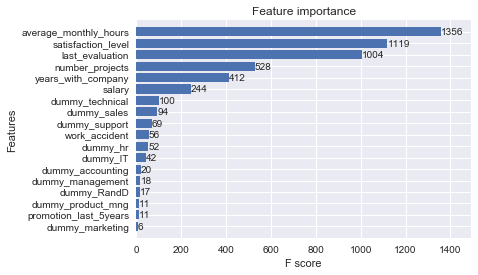

In [15]:
from xgboost import plot_importance

# We already cross-validated, so we can fit
# to the entire data set for illustrative purposes
xg = XGBClassifier(max_depth=9, n_estimators=100).fit(x,y)

plot_importance(xg, height=.8)
plt.show()

Interestingly, it's not employee satisfaction that XGBoost finds the most important -- it's average monthly hours.

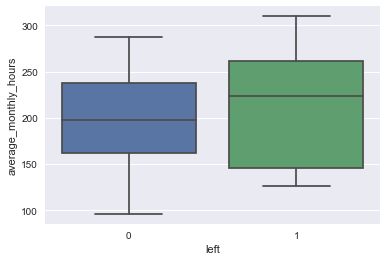

In [16]:
sns.boxplot(x='left', y='average_monthly_hours', data=data)

Let's examine the relationship between satisfaction and monthly hours among the employees who left.

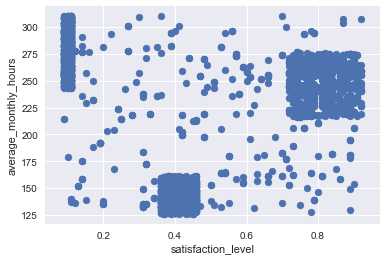

In [17]:
left = data[data.left == 1]

plt.scatter("satisfaction_level", "average_monthly_hours", data=left)
plt.xlabel('satisfaction_level')
plt.ylabel('average_monthly_hours')

Again, this graph seems a little too tidy to be real-world data. But let's analyze it anyway.

There are 3 distinct groups here:

- In the upper left, we have the people who experienced burnout (low satisfaction, lots of overtime). 
- In the upper right, we have our stars who may have left for other companies or retired.
- Near the bottom, we have the employees who are probably not a good fit for the company. They're working the standard number of hours, but are dissatisfied with their jobs.

Some employees are definitely feeling overworked.

When we plot performance review scores, we see a similar trend: it's the hardest workers who are leaving most!

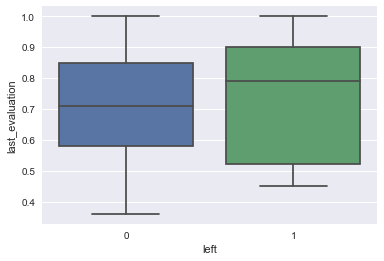

In [18]:
sns.boxplot(x='left', y='last_evaluation', data=data)

## Plotting the ROC Curve

Our model's AUC score is extremely high, but what does it *look like* when we graph it?

As far as I know, there is no built-in functionality for sklearn to plot such a graph, so I'll code it up myself.

In [19]:
xtrain, xtest, ytrain, ytest =\
train_test_split(x, y, test_size=0.25)

cap_tree = DecisionTreeClassifier(max_depth=None, min_samples_leaf=5,
                                  min_samples_split=200)\
.fit(xtrain,ytrain)

pred_proba = cap_tree.predict_proba(xtest)[:,1]

In [20]:
def results_df(ytest=ytest, pred_proba=pred_proba):

    results = pd.DataFrame()

    results['actual'] = ytest
    results['predicted'] = pred_proba

    results.sort_values('predicted', ascending=False, inplace=True)

    # Counting positive observations
    results['model_count'] = pd.Series.cumsum(results.actual)
    results['percentage'] = 1/len(results)
    results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])

    # Percentage of the total found
    results['model_select_pct'] = results['model_count']/np.sum(results['actual'])
    results['random_select_pct'] = pd.Series.cumsum(results.percentage)

    del results['percentage']
    
    return results

results = results_df()

In [21]:
results.head(10)

,actual,predicted,model_count,random_count,model_select_pct,random_select_pct
387,1,1.0,1,0.249867,0.001067,0.000267
1240,1,1.0,2,0.499733,0.002134,0.000533
78,1,1.0,3,0.749600,0.003202,0.000800
1486,1,1.0,4,0.999467,0.004269,0.001067
14769,1,1.0,5,1.249333,0.005336,0.001333
561,1,1.0,6,1.499200,0.006403,0.001600
14863,1,1.0,7,1.749067,0.007471,0.001867
14796,1,1.0,8,1.998933,0.008538,0.002133
997,1,1.0,9,2.248800,0.009605,0.002400
736,1,1.0,10,2.498667,0.010672,0.002667


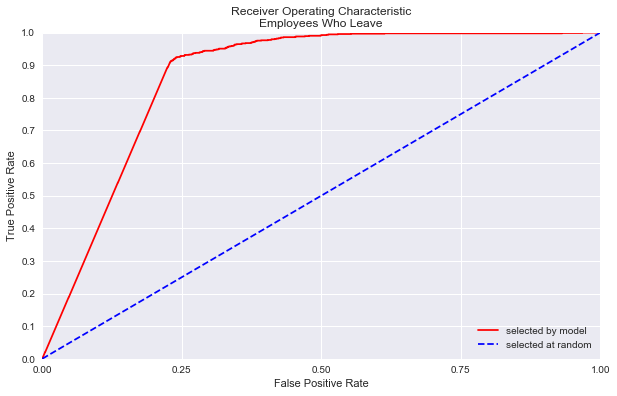

In [27]:
def plot_roc_curve(df):
    plt.plot(df.random_select_pct, df.model_select_pct, color='red',
             label='selected by model')
    plt.plot(df.random_select_pct, df.random_select_pct, color='blue',
             linestyle='--', label='selected at random')

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic\nEmployees Who Leave')
    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks(np.arange(0, 1.1, .25))
    plt.yticks(np.arange(0, 1.1, .1))
    
    plt.legend()
    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6

plot_roc_curve(results)

Honestly, I've *never* seen a model perform this well! For the top 20% of employees most likely to quit, our model is practically a crystal ball. My inner Bayesian now thinks there's an 85% chance we're using fake data.

Just to prove there's no trickery with the model itself, we can try using a less accurate algorithm. Let's try a logistic regression.

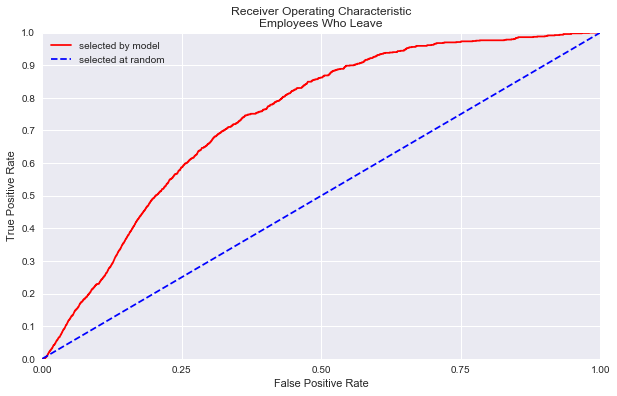

In [23]:
cap_lr = LogisticRegression().fit(xtrain, ytrain)
pred_proba_lr = cap_lr.predict_proba(xtest)[:,1]

results_lr = results_df(pred_proba=pred_proba_lr)

plot_roc_curve(results_lr)

My ROC curves usually look a bit more like this. It appears that my decision tree is prioritizing the most dissatisfied employees and flagging them as likely to leave. So it's working as intended.

# Recommendations

The decision tree is the best choice here because it's both **a)** highly accurate, and **b)** understandable by humans. Let's look at what it recommends!

In [24]:
# Fit to all data
tree = DecisionTreeClassifier(max_depth=9).fit(x, y)

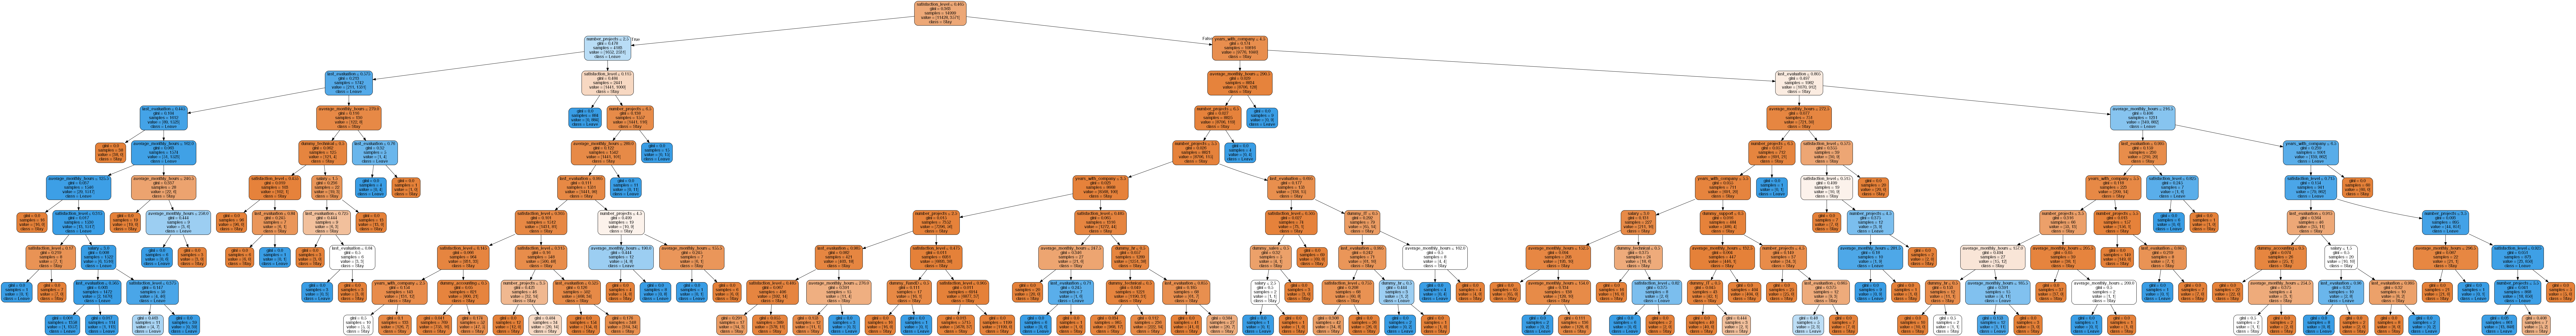

In [25]:
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Stay', 'Leave'],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

That's one heck of a tree! It *might* be useful in some circumstances, but it's probably better to sacrifice some accuracy for readability. Let's use a depth of 3 instead of 9.

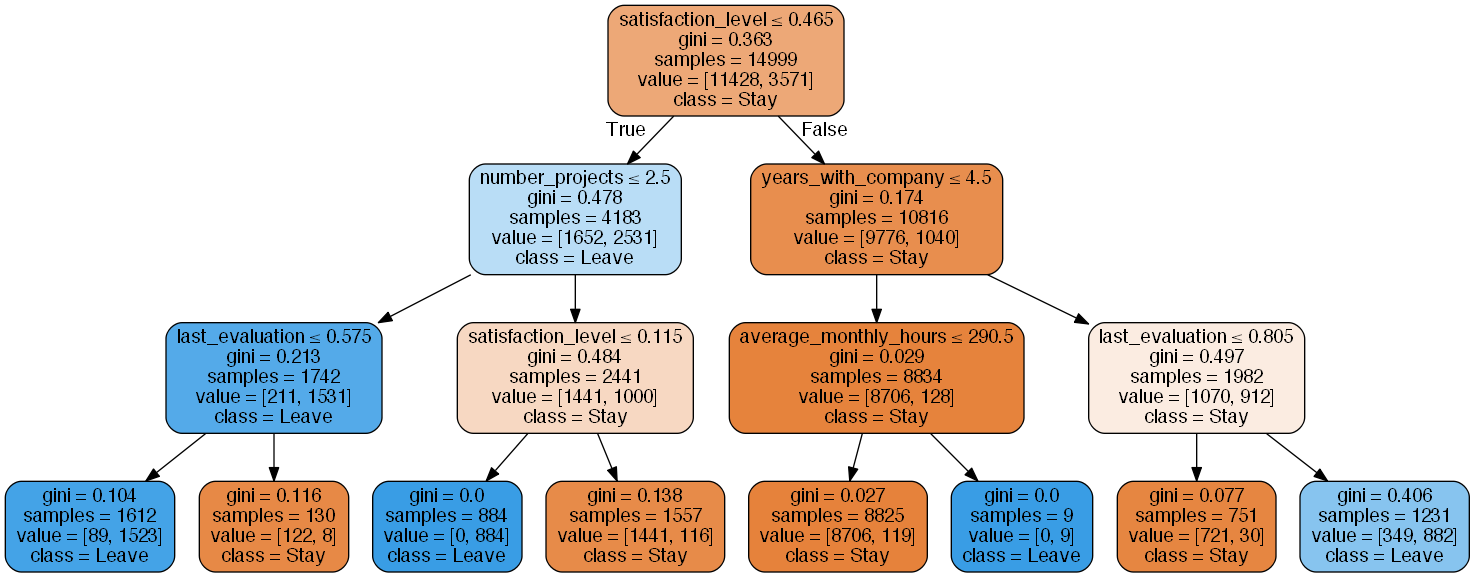

In [26]:
tree = DecisionTreeClassifier(max_depth=3).fit(x,y)

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Stay', 'Leave'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

My advice to management would be:

- Pay close attention to employee satisfaction levels. This is a great overall predictor of retention.

 
- Among dissatisfied employees, low performance ratings further contribute to leaving the company.

 
- It's a bit harder to predict retention among satisfied employees. Those with the longest tenure are more likely to leave, especially if they are high performers. This suggests that there isn't enough room for advancement at the higher levels of the company.

 
- If promotions are out of the question, we should experiment with higher salaries, flextime, or other incentives that would encourage people to stay. I'm especially concerned with the low correlation between salary and years with the company. We should be rewarding people for staying!